# Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno
import numpy as np
import deepcell
from tensorflow.python import keras
import matplotlib.pyplot as plt


/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance "classes"
erosion_width = 2  # erode edges
LOG_DIR = '/data/logs'

In [3]:
base_name = 'lab_combined_h3_train'
npz_name = '/data/npz_data/' + base_name + ".npz"
MODEL_DIR = '/data/models/' + '20191112_lab_combined'
MODEL_NAME = base_name + "_watershed_61_rf_256_dense_64_conv_2erosion"

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

### Load the Training Data

In [4]:
CHANNEL_AXIS = 3
training_data = np.load(npz_name)

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

X.shape: (7, 1024, 1024, 1) & y.shape: (7, 1024, 1024, 1)


### Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [5]:
from deepcell import model_zoo
from deepcell.training import train_model_sample

watershed_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    n_channels=X.shape[CHANNEL_AXIS],
    n_features=distance_bins,
    n_conv_filters=64,
    n_dense_filters=256)

In [6]:
MODEL_NAME

'lab_combined_h3_train_watershed_61_rf_256_dense_64_conv_2erosion'

#### Train the model

In [7]:
watershed_model = train_model_sample(
    model=watershed_model,
    dataset=npz_name, 
    model_name=MODEL_NAME,
    test_size=test_size,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=6,
    window_size=(win, win),
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    balance_classes=True,
    max_class_samples=700000,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),
    val_monitor=False,
    save_period=1)

using all data as training data
Using class weights of {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
X_train shape: (7, 1024, 1024, 1)
y_train shape: (7, 1024, 1024, 1)
Output Shape: (None, 4)
Number of Classes: 4
Training on 1 GPUs
the max_class_samples per image is 100000
analyzing image 0
the least represented class has 38420 examples
analyzing class 0
downsampling from 686011 examples per class
analyzing class 1
downsampling from 120963 examples per class
analyzing class 2
downsampling from 81975 examples per class
analyzing class 3
downsampling from 38420 examples per class
analyzing image 1
the least represented class has 33279 examples
analyzing class 0
downsampling from 717643 examples per class
analyzing class 1
downsampling from 105981 examples per class
analyzing class 2
downsampling from 70466 examples per class
analyzing class 3
downsampling from 33279 examples per class
analyzing image 2
the least represented class has 39001 examples
analyzing class 0
downsampling from 682365 examples

In [8]:
hist = np.load(os.path.join(MODEL_DIR, MODEL_NAME + ".npz"))
hist['loss_history'].tolist()['acc']

[0.6336537173481546,
 0.6520674257641473,
 0.6574960928768099,
 0.6614121455682072,
 0.6631748158060352,
 0.6659499888362617]

In [20]:
EPOCH_NAME = "_epoch_03"
watershed_weights_file = os.path.join(MODEL_DIR, MODEL_NAME + EPOCH_NAME + ".h5")

In [21]:
# load watershed model
run_watershed_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    receptive_field=receptive_field,
    n_features=distance_bins,
    input_shape=tuple(X.shape[1:]), 
    n_conv_filters=64,
    n_dense_filters=256)
run_watershed_model.load_weights(watershed_weights_file)

In [11]:
# load test data
test_data = np.load("/data/npz_data/lab_combined_h3_test.npz")

X_test, y_test = test_data["X"], test_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

X.shape: (7, 1024, 1024, 1) & y.shape: (7, 1024, 1024, 1)


In [22]:
# run the model
test_images = run_watershed_model.predict(X_test[:1, ...])

In [23]:
argmax_images = []
for j in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

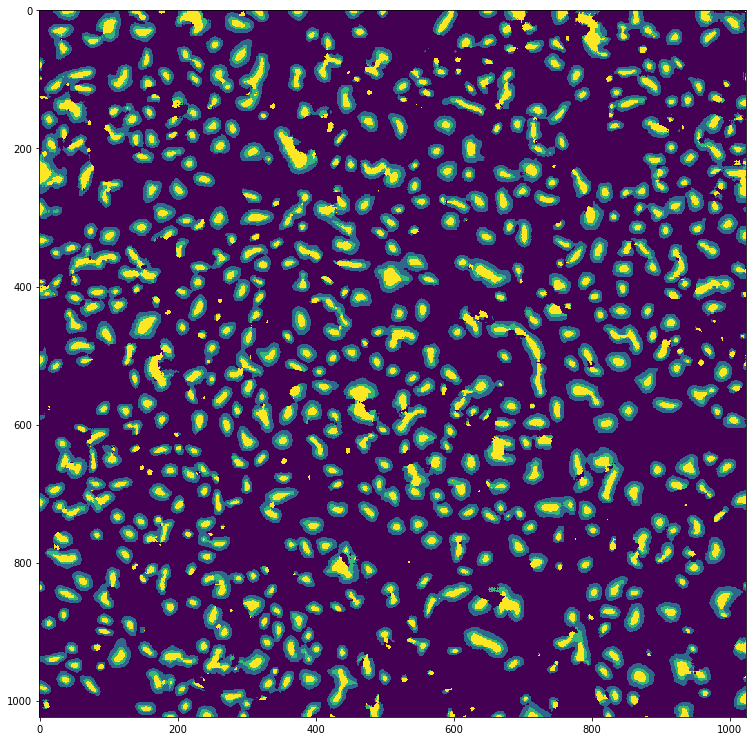

In [24]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])

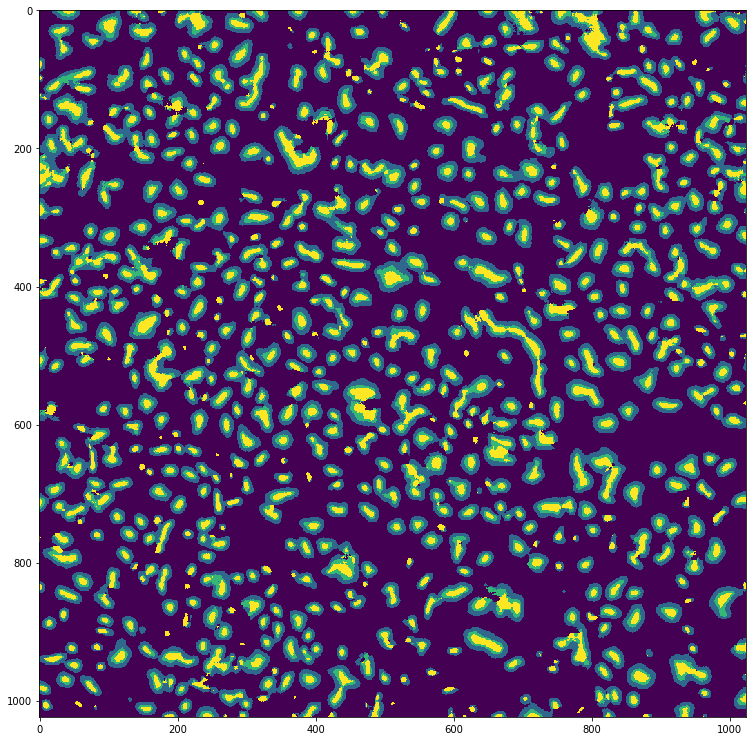

In [19]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])

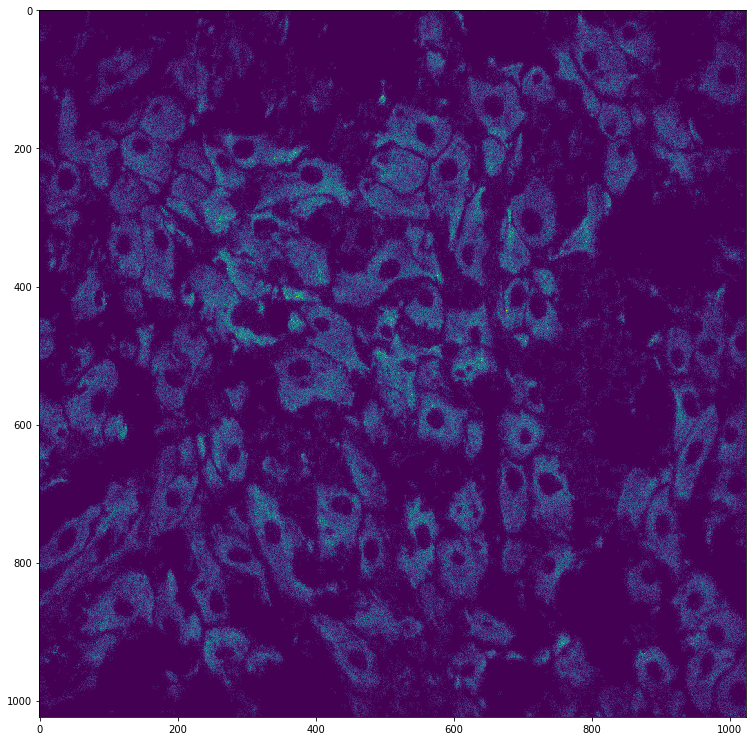

In [88]:
plt.figure(figsize = (13, 13))
plt.imshow(X_test[0, :, :, 5])